In [90]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
from math import * 


print("The current directory is: ")
print(os.getcwd())
if not os.getcwd().endswith("Abaqus-TDS-Hydrogen-Bayesian-Optimization"):
    # Move up two directories
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
print("The current directory is: ")
print(os.getcwd())

from utils.IO import *
from utils.calculation import *

The current directory is: 
c:\LocalUserData\User-data\nguyenb5\Abaqus-TDS-Hydrogen-Bayesian-Optimization
The current directory is: 
c:\LocalUserData\User-data\nguyenb5\Abaqus-TDS-Hydrogen-Bayesian-Optimization


In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
from configs.chosen_project import *
from src.stage1_global_configs import *

chosen_project_path = "configs/global_config_CP1000_RD_20C.json"

global_configs = main_global_configs(chosen_project_path)

all_paths = global_configs['all_paths']


START RUNNING FROM *** 2024-11-15 13:56:04 ***

= Stage 1: Loading configs and all paths =

Welcome to Abaqus Seq2Seq flow curve calibration project

The configurations you have chosen: 

+--------------------------+-------------------------------------------------------------------------------+
|      Global Configs      |                                  User choice                                  |
+--------------------------+-------------------------------------------------------------------------------+
|       PROJECT_PATH       | c:\LocalUserData\User-data\nguyenb5\Abaqus-TDS-Hydrogen-Bayesian-Optimization |
|         LOG_PATH         |                               log/CP1000_RD_20C                               |
|  RESULTS_INIT_DATA_PATH  |                       results_initial_data/CP1000_RD_20C                      |
| RESULTS_INIT_COMMON_PATH |                      results_initial_common/CP1000_RD_20C                     |
|  RESULTS_ITER_DATA_PATH  |                    

In [93]:
from utils.hardening_laws import *

results_init_common_path = all_paths['results_init_common_path']
results_init_data_path = all_paths['results_init_data_path']
targets_path = all_paths['targets_path']
num_measurements = global_configs['num_measurements']
param_config = global_configs['param_config']

In [94]:
# Define a function to denormalize a point
def denormalize_point(normalized_point, param_config):
    """
    normalized_point: np.array of shape (num_params)
    param_config: dictionary of parameter configurations from .json file in configs folder
    """
    denormalized_point = []
    for i, param_key in enumerate(param_config.keys()):
        param_multiplier = param_config[param_key]["exponent"]
        param_min = param_config[param_key]["lower"] * param_multiplier
        param_max = param_config[param_key]["upper"] * param_multiplier
        # Denormalize each value
        denormalized_value = normalized_point[i] * (param_max - param_min) + param_min
        denormalized_point.append(denormalized_value)
    return np.array(denormalized_point)

def denormalize_points(normalized_points, param_config):
    """
    normalized_points: np.array of shape (num_points, num_params)
    param_config: dictionary of parameter configurations from .json file in configs folder
    """
    denormalized_points = []
    for i in range(normalized_points.shape[0]):
        denormalized_point = denormalize_point(normalized_points[i], param_config)
        denormalized_points.append(denormalized_point)
    return np.array(denormalized_points)

# Define a function to normalize a point
def normalize_point(denormalized_point, param_config):
    """
    denormalized_point: np.array of shape (num_params)
    param_config: dictionary of parameter configurations from .json file in configs folder
    """
    normalized_point = []
    for i, param_key in enumerate(param_config.keys()):
        param_multiplier = param_config[param_key]["exponent"]
        param_min = param_config[param_key]["lower"] * param_multiplier
        param_max = param_config[param_key]["upper"] * param_multiplier
        # Normalize each value
        normalized_value = (denormalized_point[i] - param_min) / (param_max - param_min)
        normalized_point.append(normalized_value)
    return np.array(normalized_point)

def normalize_points(denormalized_points, param_config):
    """
    denormalized_points: np.array of shape (num_points, num_params)
    param_config: dictionary of parameter configurations from .json file in configs folder
    """
    normalized_points = []
    for i in range(denormalized_points.shape[0]):
        normalized_point = normalize_point(denormalized_points[i], param_config)
        normalized_points.append(normalized_point)
    return np.array(normalized_points)

In [95]:
# Loading the TDS_measurements.npy
sim_TDS_measurements = np.load(f"{results_init_common_path}/TDS_measurements.npy", allow_pickle=True).tolist()

features_unnormalized_array = []

for index, param_key in enumerate(param_config.keys()):
    param_values_list = np.array([params_tuple[index][1] for params_tuple in sim_TDS_measurements.keys()])
    features_unnormalized_array.append(param_values_list)

features_unnormalized_array = np.array(features_unnormalized_array).T

target_TDS_measurements = {}

df = pd.read_excel(f'{targets_path}/measurements.xlsx', engine='openpyxl')
time_TDS = df['time'].to_numpy()
C_wtppm = df['C_wtppm'].to_numpy()
C_mol = df['C_mol'].to_numpy()

for num_measurement in range(num_measurements):
    target_TDS_measurements[f"measurement_{num_measurement + 1}"] = {
        "time": time_TDS[num_measurement],
        "C_wtppm": C_wtppm[num_measurement],
        "C_mol": C_mol[num_measurement]
    }

MAE_list = []

# Calculate the known MAE when H_surface = 0
known_mae = sum(target_TDS_measurements[f"measurement_{i + 1}"]["C_mol"] for i in range(num_measurements))

for params_tuple, sim_measurements in sim_TDS_measurements.items():
    current_MAE = 0
    for sim_measurement in sim_measurements.values():
        sim_measurement_time = sim_measurement["time"]
        for target_measurement in target_TDS_measurements.values():
            target_measurement_time = target_measurement["time"]
            if sim_measurement_time == target_measurement_time:
                current_MAE += abs(sim_measurement["C_mol"] - target_measurement["C_mol"])
                break
    MAE_list.append(current_MAE)

label_array = np.array(MAE_list)


# Now we need to normalize the features_unnormalized_array and label_array

features_normalized_array = normalize_points(features_unnormalized_array, param_config)

print("Shape of features_normalized_array:")
print(features_normalized_array.shape)
print("Shape of features_unnormalized_array:")
print(features_unnormalized_array.shape)
print("Shape of label_array:")
print(label_array.shape)

print("Unnormalized features_unnormalized_array:")
print(features_unnormalized_array)
print("Unnormalized label_array:")
print(label_array)

# The normalized array should be a sobol sequence since the unnormalized array is sampled from a sobol sequence
print("Normalized features_normalized_array:")
print(features_normalized_array)

Shape of features_normalized_array:
(16, 2)
Shape of features_unnormalized_array:
(16, 2)
Shape of label_array:
(16,)
Unnormalized features_unnormalized_array:
[[5.6000000e+00 1.0000000e-11]
 [7.9750000e+00 5.0500000e-10]
 [9.1625000e+00 2.5750000e-10]
 [6.7875000e+00 7.5250000e-10]
 [7.3812500e+00 3.8125000e-10]
 [9.7562500e+00 8.7625000e-10]
 [8.5687500e+00 1.3375000e-10]
 [6.1937500e+00 6.2875000e-10]
 [6.4906250e+00 3.1937500e-10]
 [8.8656250e+00 8.1437500e-10]
 [1.0053125e+01 7.1875000e-11]
 [7.6781250e+00 5.6687500e-10]
 [7.0843750e+00 1.9562500e-10]
 [9.4593750e+00 6.9062500e-10]
 [8.2718750e+00 4.4312500e-10]
 [5.8968750e+00 9.3812500e-10]]
Unnormalized label_array:
[19.20508597  4.03920771  5.09584047  5.15465692  4.25503972 10.75757148
  2.44395282  6.4148951   5.92744258  6.7994473   3.26816468  3.88493944
  4.68061998  8.86157548  4.17551113  6.73182634]
Normalized features_normalized_array:
[[0.     0.    ]
 [0.5    0.5   ]
 [0.75   0.25  ]
 [0.25   0.75  ]
 [0.375  0.375 

In [96]:
import numpy as np

# Known MAE when H_surface = 0
known_mae = sum(target_TDS_measurements[f"measurement_{i + 1}"]["C_mol"] for i in range(num_measurements))

# Create 11 evenly spaced DL values between 0 and 1 for H_surface = 0
DL_values = np.linspace(0, 1, 6)
H_surface_values = np.zeros_like(DL_values)  # H_surface fixed at 0

# Stack H_surface and DL values to create new feature points
features_augmented = np.column_stack((H_surface_values, DL_values))

# Create labels for these new points (all equal to known_mae)
labels_augmented = np.full((6,), known_mae)

# Concatenate these new points to the existing features and labels arrays
features_normalized_augmented = np.vstack((features_normalized_array, features_augmented))
label_array_augmented = np.concatenate((label_array, labels_augmented))

# Print the augmented arrays to verify
print("Augmented Features Array (features_normalized_augmented):")
print(features_normalized_augmented)
print("Augmented Labels Array (label_array_augmented):")
print(label_array_augmented)


Augmented Features Array (features_normalized_augmented):
[[0.     0.    ]
 [0.5    0.5   ]
 [0.75   0.25  ]
 [0.25   0.75  ]
 [0.375  0.375 ]
 [0.875  0.875 ]
 [0.625  0.125 ]
 [0.125  0.625 ]
 [0.1875 0.3125]
 [0.6875 0.8125]
 [0.9375 0.0625]
 [0.4375 0.5625]
 [0.3125 0.1875]
 [0.8125 0.6875]
 [0.5625 0.4375]
 [0.0625 0.9375]
 [0.     0.    ]
 [0.     0.2   ]
 [0.     0.4   ]
 [0.     0.6   ]
 [0.     0.8   ]
 [0.     1.    ]]
Augmented Labels Array (label_array_augmented):
[19.20508597  4.03920771  5.09584047  5.15465692  4.25503972 10.75757148
  2.44395282  6.4148951   5.92744258  6.7994473   3.26816468  3.88493944
  4.68061998  8.86157548  4.17551113  6.73182634 31.174      31.174
 31.174      31.174      31.174      31.174     ]


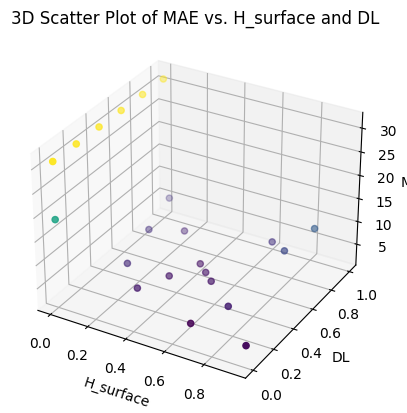

In [97]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the data
ax.scatter(features_normalized_augmented[:, 0], features_normalized_augmented[:, 1], label_array_augmented,
        c=label_array_augmented, cmap='viridis')
ax.set_xlabel('H_surface')
ax.set_ylabel('DL')
ax.set_zlabel('MAE')
ax.set_title('3D Scatter Plot of MAE vs. H_surface and DL')

plt.show()


In [127]:
import math
import torch

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

# Convert to PyTorch tensors
# Convert the augmented feature and label arrays to PyTorch tensors
train_X = torch.tensor(features_normalized_augmented, dtype=torch.float64, device=device)
train_Y = torch.tensor(label_array_augmented, dtype=torch.float64, device=device).unsqueeze(-1)  # Make sure train_Y is 2D for BoTorch

# Verify the shapes
print("train_X shape:", train_X.shape)  # Should be (number of samples, number of features)
print("train_Y shape:", train_Y.shape)  # Should be (number of samples, 1)

from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan
from botorch.models.transforms import Normalize
from gpytorch.kernels import RBFKernel, ScaleKernel, ConstantKernel, MaternKernel

# Define the kernel explicitly as an RBF kernel wrapped in a ScaleKernel
# If we dont set the ard_num_dims, the kernel will assume that all input dimensions have the same lengthscale
# It is known as an isotropic kernel

rbf_kernel = ScaleKernel(RBFKernel(ard_num_dims=train_X.shape[1])) + ConstantKernel()
rbf_kernel.to(train_X)

GP_RBF_model = SingleTaskGP(train_X=train_X, train_Y=train_Y, 
                    train_Yvar = None,
                    likelihood = None,
                    covar_module=rbf_kernel)
GP_RBF_model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(likelihood=GP_RBF_model.likelihood, model=GP_RBF_model)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_X)

from torch.optim import Adam, SGD

NUM_EPOCHS = 20000

max_learning_rate = 0.0005
min_learning_rate = 0.0001

# Initialize optimizer with the maximum learning rate
optimizer = Adam([{'params': GP_RBF_model.parameters()}], lr=max_learning_rate)

# Calculate the decrement step for the learning rate
lr_decrement = (max_learning_rate - min_learning_rate) / NUM_EPOCHS

GP_RBF_model.train()

# Hyperparameters in the Multidimensional RBF Kernel
# In the multidimensional case, the RBF kernel has:
# One output scale parameter sigma for the entire kernel, which controls the overall variance of the function values.
# One lengthscale parameter per dimension controls the smoothness in the i-th input dimension.

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = GP_RBF_model(train_X)
    # Compute negative marginal log likelihood
    loss = - mll(output, GP_RBF_model.train_targets)
    # back prop gradients
    loss.backward()
    # print every 2000 iterations
    if (epoch + 1) % 2000 == 0:
        # Retrieve lengthscale, noise, and output scale for tracking
        scale_kernel = list(GP_RBF_model.covar_module.sub_kernels())[0]
        rbf_kernel = list(GP_RBF_model.covar_module.sub_kernels())[1]
        # rbf_kernel is also scale_kernel.base_kernel
        constant_kernel = list(GP_RBF_model.covar_module.sub_kernels())[2]
        lengthscales = rbf_kernel.lengthscale.tolist()[0]
        noise = GP_RBF_model.likelihood.noise.tolist()
        sigma = math.sqrt(scale_kernel.outputscale.item())  # Compute σ from σ^2
        constant_value = constant_kernel.constant.item()     # Get the optimized constant value
        
        # Print kernel parameters
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} ",
            f"lengthscale: {[round(ls, 6) for ls in lengthscales]} ",
            f"noise: {[round(n, 6) for n in noise]} ",
            f"sigma: {round(sigma, 6)} ",
            f"constant: {round(constant_value, 6)}"
        )

    # Update optimizer learning rate linearly
    for param_group in optimizer.param_groups:
        param_group['lr'] = max(min_learning_rate, max_learning_rate - lr_decrement * epoch)

    optimizer.step()

train_X shape: torch.Size([22, 2])
train_Y shape: torch.Size([22, 1])
Epoch 2000/20000 - Loss: 1.215  lengthscale: [0.327097, 1.269938]  noise: [0.322801]  sigma: 1.087005  constant: 0.33226
Epoch 4000/20000 - Loss: 0.963  lengthscale: [0.172617, 1.826904]  noise: [0.157922]  sigma: 1.091571  constant: 0.163645
Epoch 6000/20000 - Loss: 0.840  lengthscale: [0.096059, 2.223639]  noise: [0.090713]  sigma: 0.861471  constant: 0.076159
Epoch 8000/20000 - Loss: 0.786  lengthscale: [0.053944, 2.246403]  noise: [0.0648]  sigma: 0.641078  constant: 0.035511
Epoch 10000/20000 - Loss: 0.772  lengthscale: [0.041669, 1.678791]  noise: [0.058361]  sigma: 0.581901  constant: 0.018874
Epoch 12000/20000 - Loss: 0.767  lengthscale: [0.038204, 1.378834]  noise: [0.056302]  sigma: 0.571382  constant: 0.011444
Epoch 14000/20000 - Loss: 0.765  lengthscale: [0.037251, 1.346199]  noise: [0.056031]  sigma: 0.568283  constant: 0.007599
Epoch 16000/20000 - Loss: 0.763  lengthscale: [0.036732, 1.344458]  noise: [

In [129]:
import math
import torch

# Use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

# Convert the augmented feature and label arrays to PyTorch tensors
train_X = torch.tensor(features_normalized_augmented, dtype=torch.float64, device=device)
train_Y = torch.tensor(label_array_augmented, dtype=torch.float64, device=device).unsqueeze(-1)  # Make sure train_Y is 2D for BoTorch

# Verify the shapes
print("train_X shape:", train_X.shape)  # Should be (number of samples, number of features)
print("train_Y shape:", train_Y.shape)  # Should be (number of samples, 1)

from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam

# Define the kernel as a Matern kernel wrapped in a ScaleKernel
# Setting `ard_num_dims` enables a separate lengthscale for each input dimension
matern_kernel = ScaleKernel(MaternKernel(nu=0.5, ard_num_dims=train_X.shape[1])) + ConstantKernel()
matern_kernel.to(train_X)

# Create the GP model with the Matern kernel
GP_Matern_model = SingleTaskGP(
    train_X=train_X, 
    train_Y=train_Y, 
    train_Yvar=None,
    likelihood=None,
    covar_module=matern_kernel
)
GP_Matern_model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

# Set up the marginal log likelihood
mll = ExactMarginalLogLikelihood(likelihood=GP_Matern_model.likelihood, model=GP_Matern_model)
mll = mll.to(train_X)

# Initialize optimizer with the maximum learning rate
NUM_EPOCHS = 20000
max_learning_rate = 0.0005
min_learning_rate = 0.0001
optimizer = Adam([{'params': GP_Matern_model.parameters()}], lr=max_learning_rate)

# Calculate the decrement step for the learning rate
lr_decrement = (max_learning_rate - min_learning_rate) / NUM_EPOCHS

GP_Matern_model.train()

# Training loop
for epoch in range(NUM_EPOCHS):
    # Clear gradients
    optimizer.zero_grad()
    # Forward pass through the model to obtain the output MultivariateNormal
    output = GP_Matern_model(train_X)
    # Compute negative marginal log likelihood
    loss = -mll(output, GP_Matern_model.train_targets)
    # Backprop gradients
    loss.backward()
    
    # Print parameters every 2000 iterations
    if (epoch + 1) % 2000 == 0:
        # Retrieve lengthscale, noise, and output scale for tracking
        scale_kernel = list(GP_Matern_model.covar_module.sub_kernels())[0]
        rbf_kernel = list(GP_Matern_model.covar_module.sub_kernels())[1]
        # rbf_kernel is also scale_kernel.base_kernel
        constant_kernel = list(GP_Matern_model.covar_module.sub_kernels())[2]
        lengthscales = rbf_kernel.lengthscale.tolist()[0]
        noise = GP_Matern_model.likelihood.noise.tolist()
        sigma = math.sqrt(scale_kernel.outputscale.item())  # Compute σ from σ^2
        constant_value = constant_kernel.constant.item()     # Get the optimized constant value
        
        # Print kernel parameters
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} ",
            f"lengthscale: {[round(ls, 6) for ls in lengthscales]} ",
            f"noise: {[round(n, 6) for n in noise]} ",
            f"sigma: {round(sigma, 6)} ",
            f"constant: {round(constant_value, 6)}"
        )

    # Update optimizer learning rate linearly
    for param_group in optimizer.param_groups:
        param_group['lr'] = max(min_learning_rate, max_learning_rate - lr_decrement * epoch)

    optimizer.step()


train_X shape: torch.Size([22, 2])
train_Y shape: torch.Size([22, 1])
Epoch 2000/20000 - Loss: 1.274  lengthscale: [0.318724, 1.268784]  noise: [0.323874]  sigma: 0.803859  constant: 0.324105
Epoch 4000/20000 - Loss: 1.000  lengthscale: [0.162007, 1.854572]  noise: [0.155275]  sigma: 0.710417  constant: 0.146564
Epoch 6000/20000 - Loss: 0.859  lengthscale: [0.09315, 2.416386]  noise: [0.086476]  sigma: 0.632371  constant: 0.068745
Epoch 8000/20000 - Loss: 0.814  lengthscale: [0.064002, 2.933273]  noise: [0.061574]  sigma: 0.591669  constant: 0.034997
Epoch 10000/20000 - Loss: 0.800  lengthscale: [0.054317, 3.40577]  noise: [0.057354]  sigma: 0.578064  constant: 0.019777
Epoch 12000/20000 - Loss: 0.793  lengthscale: [0.052442, 3.844074]  noise: [0.057248]  sigma: 0.574345  constant: 0.012303
Epoch 14000/20000 - Loss: 0.788  lengthscale: [0.052143, 4.240449]  noise: [0.057283]  sigma: 0.572856  constant: 0.008255
Epoch 16000/20000 - Loss: 0.785  lengthscale: [0.052143, 4.584211]  noise: 

In [130]:
# Define new test points in the normalized feature space
test_X = torch.tensor([
    [0.2, 0.5],  # Example new parameter combination in normalized space
    [0.7, 0.3]
], dtype=dtype, device=device)

# Set the model to evaluation mode
GP_RBF_model.eval()
with torch.no_grad():
    # Obtain the posterior distribution
    posterior = GP_RBF_model.posterior(test_X)
    mean = posterior.mean  # Predicted mean
    stddev = posterior.variance.sqrt()  # Predicted standard deviation (uncertainty)
    
print("Predicted mean MAE:", mean.cpu().numpy())
print("Predicted standard deviation (uncertainty):", stddev.cpu().numpy())


Predicted mean MAE: [[5.92592557]
 [6.58130606]]
Predicted standard deviation (uncertainty): [[3.11411369]
 [3.64567028]]


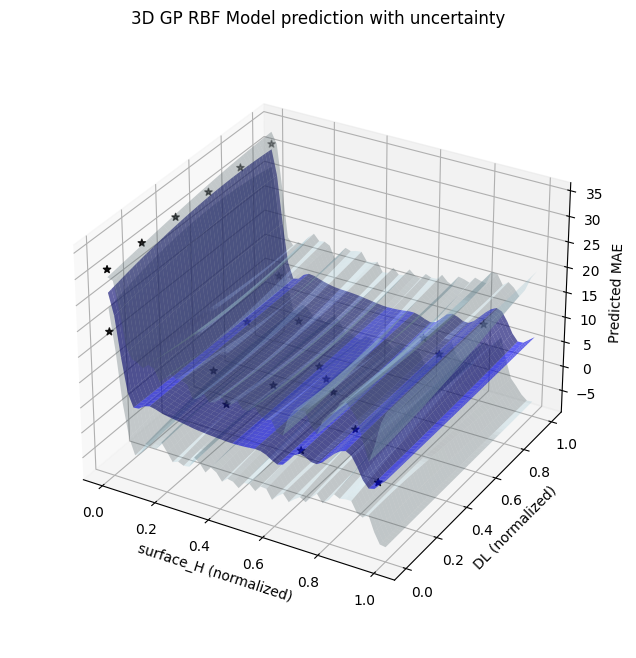

In [131]:
import numpy as np
import torch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt


# Create a 2D grid of points for prediction
x1 = np.linspace(0, 1, 50)  # Range for the first feature (surface_H)
x2 = np.linspace(0, 1, 50)  # Range for the second feature (DL)
X1, X2 = np.meshgrid(x1, x2)  # Create a grid
grid_X = torch.tensor(np.c_[X1.ravel(), X2.ravel()], dtype=dtype, device=device)

# Make predictions on the grid
GP_RBF_model.eval()
with torch.no_grad():
    posterior = GP_RBF_model.posterior(grid_X)
    mean = posterior.mean.cpu().numpy().reshape(50, 50)
    lower, upper = posterior.mvn.confidence_region()
    lower = lower.cpu().numpy().reshape(50, 50)
    upper = upper.cpu().numpy().reshape(50, 50)

# Plot the mean predictions as a 3D surface and the uncertainty as shading
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot for the mean
ax.plot_surface(X1, X2, mean, color='blue', alpha=0.6, rstride=1, cstride=1, edgecolor='none')

# Shaded area for the uncertainty
ax.plot_surface(X1, X2, upper, color='lightblue', alpha=0.3, rstride=1, cstride=1, edgecolor='none')
ax.plot_surface(X1, X2, lower, color='lightblue', alpha=0.3, rstride=1, cstride=1, edgecolor='none')

# Scatter plot of training data points
ax.scatter(train_X[:, 0].cpu().numpy(), train_X[:, 1].cpu().numpy(), train_Y.cpu().numpy(), color='black', marker='*', s=30)
ax.set_box_aspect(aspect=None, zoom=0.9)
# Labels
ax.set_xlabel("surface_H (normalized)")
ax.set_ylabel("DL (normalized)")
ax.set_zlabel("Predicted MAE")
ax.set_title("3D GP RBF Model prediction with uncertainty")

plt.show()

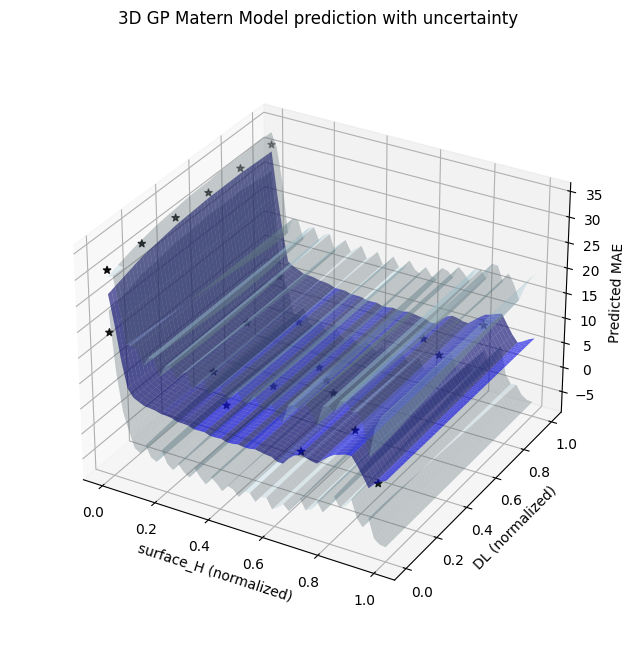

In [132]:
import numpy as np
import torch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt


# Create a 2D grid of points for prediction
x1 = np.linspace(0, 1, 50)  # Range for the first feature (surface_H)
x2 = np.linspace(0, 1, 50)  # Range for the second feature (DL)
X1, X2 = np.meshgrid(x1, x2)  # Create a grid
grid_X = torch.tensor(np.c_[X1.ravel(), X2.ravel()], dtype=dtype, device=device)

# Make predictions on the grid
GP_Matern_model.eval()
with torch.no_grad():
    posterior = GP_Matern_model.posterior(grid_X)
    mean = posterior.mean.cpu().numpy().reshape(50, 50)
    lower, upper = posterior.mvn.confidence_region()
    lower = lower.cpu().numpy().reshape(50, 50)
    upper = upper.cpu().numpy().reshape(50, 50)

# Plot the mean predictions as a 3D surface and the uncertainty as shading
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot for the mean
ax.plot_surface(X1, X2, mean, color='blue', alpha=0.6, rstride=1, cstride=1, edgecolor='none')

# Shaded area for the uncertainty
ax.plot_surface(X1, X2, upper, color='lightblue', alpha=0.3, rstride=1, cstride=1, edgecolor='none')
ax.plot_surface(X1, X2, lower, color='lightblue', alpha=0.3, rstride=1, cstride=1, edgecolor='none')

# Scatter plot of training data points
ax.scatter(train_X[:, 0].cpu().numpy(), train_X[:, 1].cpu().numpy(), train_Y.cpu().numpy(), color='black', marker='*', s=30)
ax.set_box_aspect(aspect=None, zoom=0.9)
# Labels
ax.set_xlabel("surface_H (normalized)")
ax.set_ylabel("DL (normalized)")
ax.set_zlabel("Predicted MAE")
ax.set_title("3D GP Matern Model prediction with uncertainty")

plt.show()

### Bayesian Optimization

In [ ]:
import torch
from botorch.acquisition import LogExpectedImprovement, ProbabilityOfImprovement, UpperConfidenceBound
from botorch.optim import optimize_acqf

# Define bounds for the parameters (assuming normalized range [0, 1] for each)

num_params = features_normalized_array.shape[1]
bounds = torch.tensor([[0.0] * num_params, [1.0] * num_params], dtype=dtype, device=device)

# Step 1: Define the acquisition function (Expected Improvement)
best_f = train_Y.min()  # Best observed MAE so far
logEI_acq = LogExpectedImprovement(model=GP_model, best_f=best_f, maximize=False)  # Set maximize=False to minimize MAE
POI_acq = ProbabilityOfImprovement(model=GP_model, best_f=best_f, maximize=False)  # Set maximize=False to minimize MAE
UCB_acq = UpperConfidenceBound(model=GP_model, beta=0.1, maximize=False)  # Set beta=0.1 for UCB

# Step 2: Optimize the acquisition function to get the next best point
# Here, we set `q=1` for single candidate suggestion
logEI_candidate, logEI_acq_value = optimize_acqf(
    acq_function=logEI_acq,
    bounds=bounds,
    q=1,  # This must be 1. If use more than 1, refer to q version, such as qLogExpectedImprovement, etc
    num_restarts=10,  # Number of restarts for optimization
    raw_samples=500,  # Number of raw samples to initialize optimization
    options={
        "batch_limit": 50,
        "max_iter": 200,
    }
)

POI_candidate, POI_acq_value = optimize_acqf(
    acq_function=POI_acq,
    bounds=bounds,
    q=1,  # This must be 1. If use more than 1, refer to q version, such as qLogExpectedImprovement, etc
    num_restarts=10,  # Number of restarts for optimization
    raw_samples=500,  # Number of raw samples to initialize optimization
    options={
        "batch_limit": 50,
        "max_iter": 200,
    }
)

UCB_candidate, UCB_acq_value = optimize_acqf(
    acq_function=UCB_acq,
    bounds=bounds,
    q=1,  # This must be 1. If use more than 1, refer to q version, such as qLogExpectedImprovement, etc
    num_restarts=10,  # Number of restarts for optimization
    raw_samples=500,  # Number of raw samples to initialize optimization
    options={
        "batch_limit": 50,
        "max_iter": 200,
    }
)

# Now we need to denormalize the suggested point to get the actual parameter values
logEI_suggested_point = logEI_candidate.cpu().numpy().reshape(-1)
POI_suggested_point = POI_candidate.cpu().numpy().reshape(-1)
UCB_suggested_point = UCB_candidate.cpu().numpy().reshape(-1)

logEI_acq_value = logEI_acq_value.cpu().numpy().reshape(-1)
POI_acq_value = POI_acq_value.cpu().numpy().reshape(-1)
UCB_acq_value = UCB_acq_value.cpu().numpy().reshape(-1)

print("Suggested point to evaluate (logEI) (normalized):", logEI_suggested_point)
print("Suggested point predicted value  (logEI) (normalized):", logEI_acq_value)
print("Suggested point to evaluate (POI) (normalized):", POI_suggested_point)
print("Suggested point predicted value  (POI) (normalized):", POI_acq_value)
print("Suggested point to evaluate (UCB) (normalized):", UCB_suggested_point)
print("Suggested point predicted value  (UCB) (normalized):", UCB_acq_value)

Suggested point to evaluate (logEI) (normalized): [0.60555357 1.        ]
Suggested point predicted value  (logEI) (normalized): [0.23166107]
Suggested point to evaluate (POI) (normalized): [0.61145104 0.18100306]
Suggested point predicted value  (POI) (normalized): [0.42863481]
Suggested point to evaluate (UCB) (normalized): [0.60735404 0.19958619]
Suggested point predicted value  (UCB) (normalized): [-2.00950807]


In [ ]:


# Denormalize each suggested point
logEI_suggested_point_denorm = denormalize_point(logEI_suggested_point, param_config)
POI_suggested_point_denorm = denormalize_point(POI_suggested_point, param_config)
UCB_suggested_point_denorm = denormalize_point(UCB_suggested_point, param_config)

# Print the denormalized points
print("Suggested point to evaluate (logEI) (denormalized):", logEI_suggested_point_denorm)
print("Suggested point to evaluate (POI) (denormalized):", POI_suggested_point_denorm)
print("Suggested point to evaluate (UCB) (denormalized):", UCB_suggested_point_denorm)


Suggested point to evaluate (logEI) (denormalized): [8.47637948e+00 1.00000000e-09]
Suggested point to evaluate (POI) (denormalized): [8.50439242e+00 1.89193029e-10]
Suggested point to evaluate (UCB) (denormalized): [8.48493169e+00 2.07590330e-10]
